# Book 2 - Selecionamento de Features, Validação, Balanceamento

Este notebook serviu como registro prático e teórico no meu aprendizado de Machine Learning.

`Enriqueci este notebook com anotações adicionais e aplicações práticas tornando-o uma referência valiosa para consultas e implementações em futuros projetos reais.`

Espero que este material inspire outros a explorar ainda mais o fascinante mundo do Machine Learning. 

No notebook presente tem todos os topicos dos notebook anteriores, porém sendo acrescentado e aprofundado com anotações dos seguintes tópicos:

**Importância das Features**: Técnicas para identificar as características mais influentes.
- **Select From Model**  
- **SelectKBest**
- **RFE**
- **RFECV**: RFE + Validação Cruzada

**Técnicas de Validação Cruzada**
- **KFolds**: Validação cruzada classica por kfolds.
- **StratifiedKFold**: Validação cruzada estratificada.

**Técnicas de Balanceamento de Dados**  
- **Oversampling - SMOTE**: Criação de dados sintéticos.
- **Undersampling - NearMiss**: Redução de amostras na classe majoritária.
- **Upsampling**: Redução da classe majoritária
- **Downsampling**: Redução a quantidade de amostras da classe majoritária.

Compartilhar conhecimento é uma alegria—viva ao aprendizado contínuo, boa pratica e bons estudo a quem estiver lendo, abraços!

# Funções, bibliotecas e Dataframe ficticios

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('dark_background')
%matplotlib inline

# Manipulação e Tratamento de dados
import openpyxl
import pandas as pd
import numpy as np
from numpy import NaN

#ignorando Warning inuteis
import warnings 
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [2]:
# Carregar os dados
url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'
df = pd.read_csv(url)

# Identificar colunas a serem removidas # Remover colunas inúteis
columns_to_drop = ['PassengerId', 'Name', 'Ticket', 'Cabin']
df = df.drop(columns=columns_to_drop)
df = df.dropna()

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Sex       712 non-null    object 
 3   Age       712 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Fare      712 non-null    float64
 7   Embarked  712 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 50.1+ KB


In [4]:
colunas_cat = ['Pclass','Sex','Embarked']
for coluna in colunas_cat:
    df[coluna] = df[coluna].astype('O')

In [5]:
x = df.drop('Survived', axis=1)
y = df['Survived']

In [6]:
# DUMMYRIZAÇÃO
colunas_categoricas = []
colunas_binarias = []
colunas_mais3_categorias = []

for coluna in x.columns:
    if df[coluna].dtype == 'O':
        categorias = x[coluna].unique()
        if len(categorias) == 2:
            print('2 niveis:', coluna, '=>', categorias)
            colunas_categoricas.append(coluna)
            colunas_binarias.append(coluna)
        else:
            print('3 niveis:', coluna, '=>', categorias)
            colunas_categoricas.append(coluna)
            colunas_mais3_categorias.append(coluna)

############################################################################################
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder #transformando colunas com 2 categorias em 0 e 1

coluna = x.columns
one_hot = make_column_transformer((
    OneHotEncoder(drop='if_binary'), #caso a coluna tenha apenas 2 categorias 
    colunas_categoricas), #passando quais são essas colunas
    remainder = 'passthrough', sparse_threshold=0) #oque deve ser feito com as outras

#Aplicando transformação
x = one_hot.fit_transform(x)

#Os novos nomes das colunas #'onehotencoder=transformadas; 'remainder'=não transformadas
novos_nomes_colunas = one_hot.get_feature_names_out(coluna)

x = pd.DataFrame(x, columns = novos_nomes_colunas) #alterando de volta
x_columns = x.columns.tolist() 

############################################################################################
# NORMALIZAÇÃO
from sklearn.preprocessing import MinMaxScaler
normalizacao = MinMaxScaler()
x = normalizacao.fit_transform(x)

#df['Close_padronizada'] = (df[coluna] - df[coluna].mean()) / df[coluna].std()
#df['Close_normalizada'] = (df[coluna] - df[coluna].min()) / (df[coluna].max() - df[coluna].min())

############################################################################################
# DEFININDO A VARIAVEL DEPENDENTE
from sklearn.preprocessing import LabelEncoder
y = LabelEncoder().fit_transform(y)

############################################################################################
x_inteiro = x
y_inteiro = y

# DIVIDINDO BASE EM TREINO E TESTE
from sklearn.model_selection import train_test_split
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, 
                                                    stratify = y, #para manter a proporção da Var Dep nos splits
                                                    random_state = 5) #raiz da aleatoridade
# test_size = 0.25 #porcentagem que ira ser separado para testes

print(x_treino.shape, x_teste.shape)
print(y_treino.shape, y_teste.shape)

3 niveis: Pclass => [3 1 2]
2 niveis: Sex => ['male' 'female']
3 niveis: Embarked => ['S' 'C' 'Q']
(534, 11) (178, 11)
(534,) (178,)


In [7]:
# Função para avaliação de modelos exibindo metricas de avaliação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay


def avaliar_modelo(y_verdadeiro, y_predito, conjunto_nome):
    """
    Função para avaliar e imprimir o relatório de classificação e a matriz de confusão.
    """
    #if conjunto_nome == "Treino":
     #   pass
    #else:
    print('*' * 70)
    print("Relatório de Classificação para o Conjunto de", conjunto_nome,":\n")
    print(classification_report(y_verdadeiro, y_predito))
    
    print('*' * 55)
    
    print("Matriz de Confusão para o Conjunto de", conjunto_nome,":\n")
    print(confusion_matrix(y_verdadeiro, y_predito))
    print('*' * 70)

    display(RocCurveDisplay.from_predictions(y_verdadeiro, y_predito, name = conjunto_nome))

###############################################################################################
# ou pode-se tbm carregar através de:
'''
import requests
arquivo = 'ML_supervised_learning'
url = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + arquivo + ".py"
response = requests.get(url)
code = response.text
exec(code)
'''


'\nimport requests\narquivo = \'ML_supervised_learning\'\nurl = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + arquivo + ".py"\nresponse = requests.get(url)\ncode = response.text\nexec(code)\n'

## Modelo Dummy Classifier

**********************************************************************
Relatório de Classificação para o Conjunto de Treino :

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       318
           1       0.00      0.00      0.00       216

    accuracy                           0.60       534
   macro avg       0.30      0.50      0.37       534
weighted avg       0.35      0.60      0.44       534

*******************************************************
Matriz de Confusão para o Conjunto de Treino :

[[318   0]
 [216   0]]
**********************************************************************


**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.60      1.00      0.75       106
           1       0.00      0.00      0.00        72

    accuracy                           0.60       178
   macro avg       0.30      0.50      0.37       178
weighted avg       0.35      0.60      0.44       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[106   0]
 [ 72   0]]
**********************************************************************


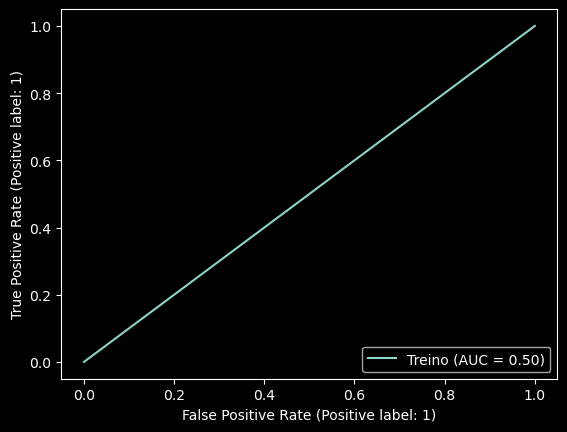

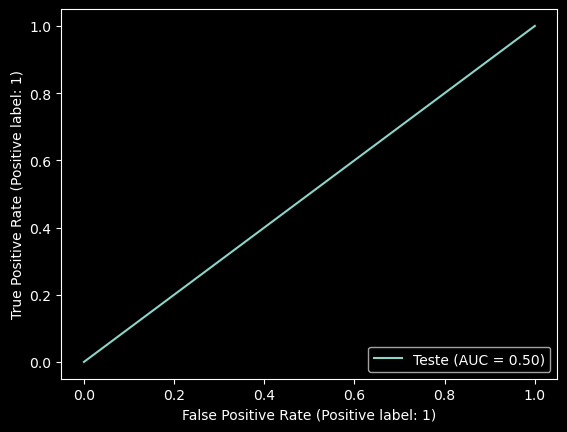

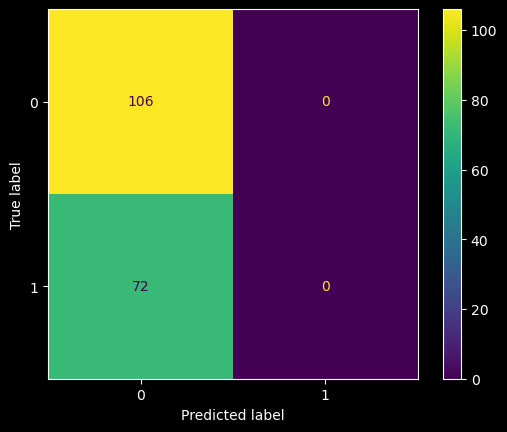

In [8]:
# MODELO BASE
from sklearn.dummy import DummyClassifier
classificador = DummyClassifier()

#######################################################################################
# Treinamento do Modelo
classificador.fit(x_treino, y_treino)

# Avaliação no conjunto de treino # Verificando Over/Under(Fitting)
previsoes_treino = classificador.predict(x_treino)
avaliar_modelo(y_treino, previsoes_treino, "Treino")

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = classificador.predict(x_teste)
avaliar_modelo(y_teste, previsoes, "Teste")

##############################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matriz_confusao = confusion_matrix(y_teste, previsoes)
visualizacao = ConfusionMatrixDisplay(confusion_matrix= matriz_confusao)
visualizacao.plot();
#######################################################################################

## Decision Tree

**********************************************************************
Relatório de Classificação para o Conjunto de Treino :

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       318
           1       0.82      0.72      0.76       216

    accuracy                           0.82       534
   macro avg       0.82      0.80      0.81       534
weighted avg       0.82      0.82      0.82       534

*******************************************************
Matriz de Confusão para o Conjunto de Treino :

[[283  35]
 [ 61 155]]
**********************************************************************


**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       106
           1       0.86      0.71      0.78        72

    accuracy                           0.84       178
   macro avg       0.84      0.82      0.82       178
weighted avg       0.84      0.84      0.83       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[98  8]
 [21 51]]
**********************************************************************


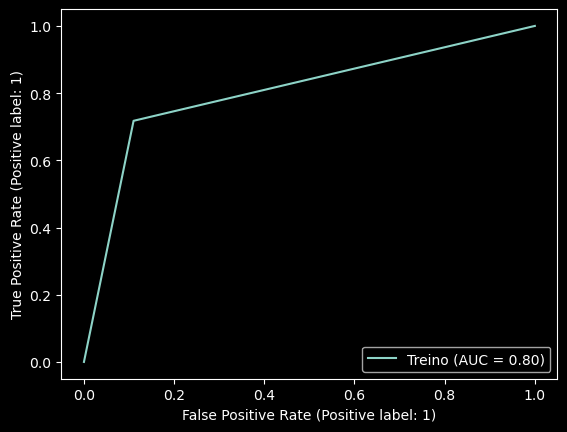

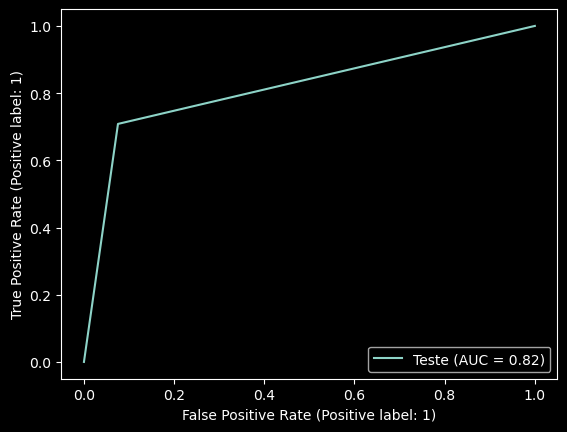

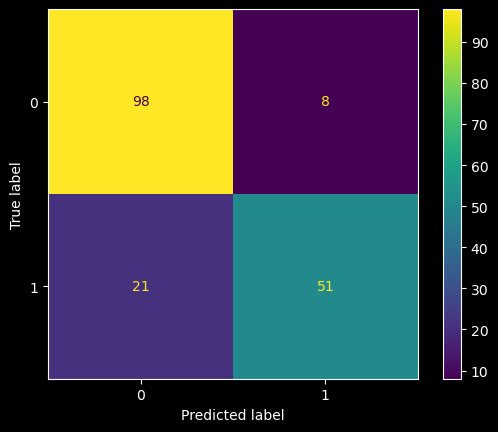

In [9]:
# APLICANDO MODELO
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

classificador = DecisionTreeClassifier(random_state=5, max_depth = 3)
#######################################################################################
# Treinamento do Modelo
classificador.fit(x_treino, y_treino)

# Avaliação no conjunto de treino # Verificando Over/Under(Fitting)
previsoes_treino = classificador.predict(x_treino)
avaliar_modelo(y_treino, previsoes_treino, "Treino")

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = classificador.predict(x_teste)
avaliar_modelo(y_teste, previsoes, "Teste")

##############################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matriz_confusao = confusion_matrix(y_teste, previsoes)
visualizacao = ConfusionMatrixDisplay(confusion_matrix= matriz_confusao)
visualizacao.plot();
#######################################################################################

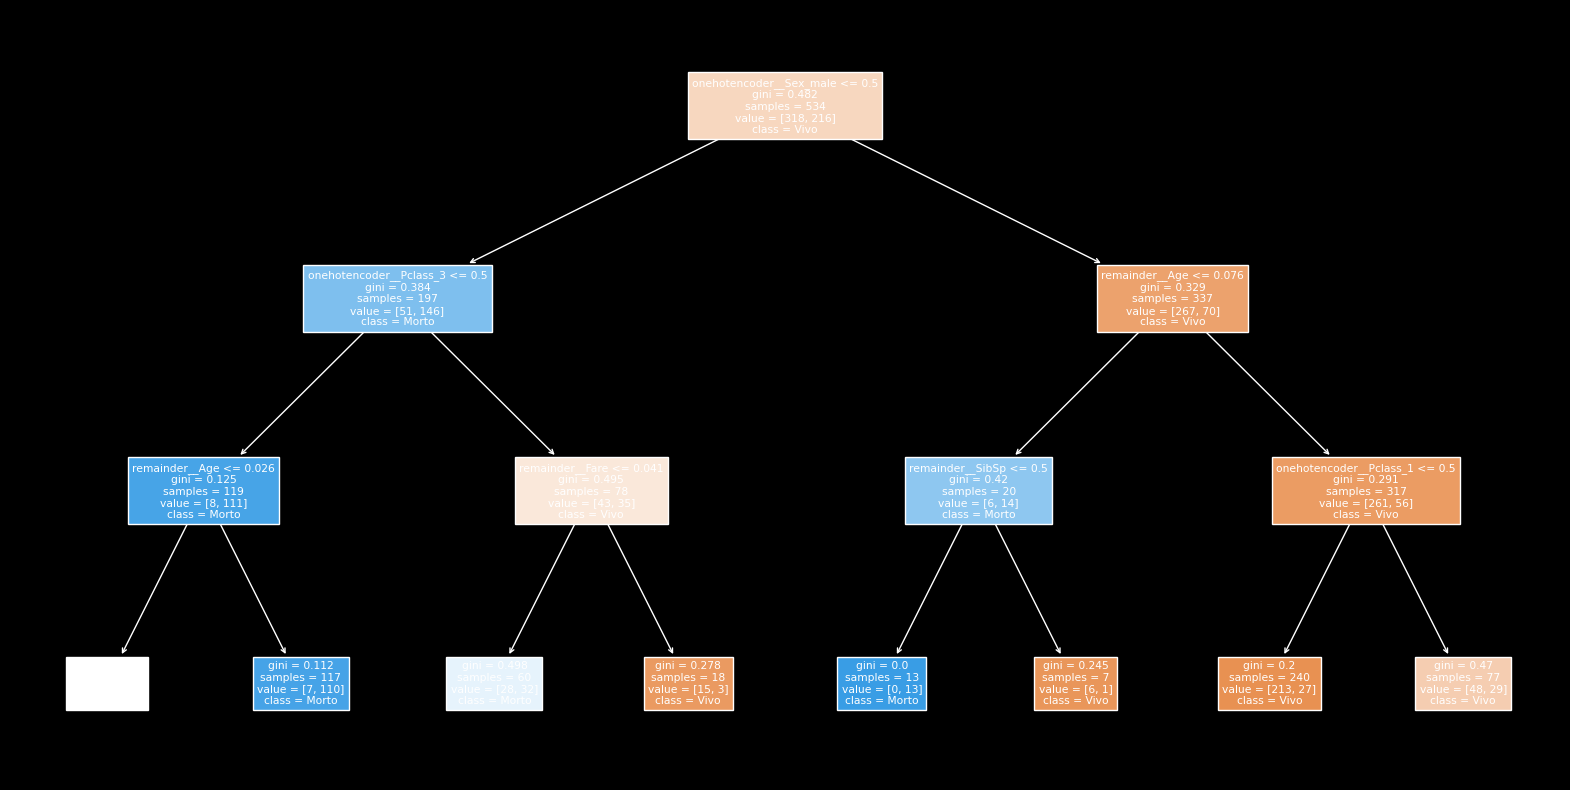

In [10]:
# Visualização da Árvore de Decisão
plt.figure(figsize=(20,10))

plot_tree(classificador, 
          filled = True, #Coloração das caixas do grafico
          class_names = ['Vivo', 'Morto'],
          feature_names=x_columns)

plt.show()

# Feature Importance

Após treinar um modelo decision tree é possivel traçar `Feature Importance` uma importância das características é uma métrica que indica o quão útil ou valiosa cada característica foi na construção do modelo de árvore de decisão. Essa métrica é calculada durante a construção da árvore e resulta da contribuição de cada característica para a pureza dos nós, ou seja, o quanto a característica ajudou a tornar as decisões do modelo mais claras e menos aleatórias.

O cálculo da importância de uma característica geralmente envolve o seguinte:

- **Redução do Impureza:** A importância de uma característica é calculada com base na redução da impureza que ela proporciona. A impureza de um nó na árvore é medida por critérios como Gini ou entropia, que quantificam o quão misturadas estão as classes dentro de um nó. Características que melhor dividem os dados, resultando em nós mais puros, são consideradas mais importantes.

- **Ponderação por Amostras:** A redução de impureza trazida por uma característica é ponderada pelo número de amostras que passam pelo nó. Isso significa que características que influenciam decisões em nós com muitas amostras têm uma importância maior, refletindo sua utilidade em escala mais ampla dentro do modelo.

- **Agregação:** A importância total de uma característica é a soma de todas as reduções de impureza que ela proporciona, ponderadas pelo número de amostras em todos os nós que ela influencia.


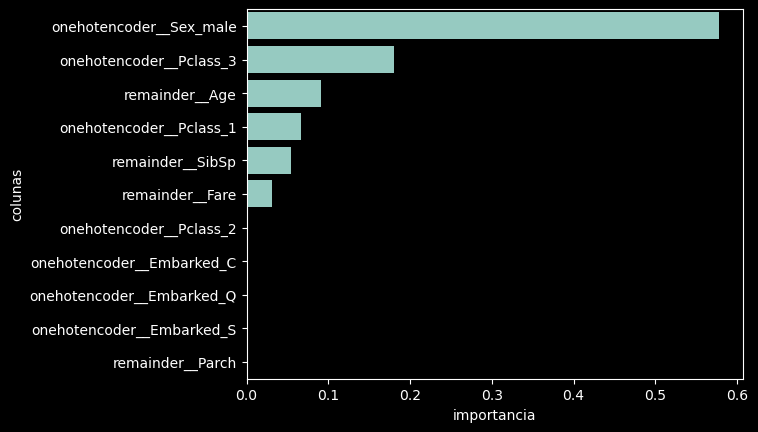

In [11]:
importancias = pd.DataFrame({'colunas': x_columns, 
                            'importancia': classificador.feature_importances_})
importancias = importancias.sort_values(by='importancia', ascending=False)
importancias

import seaborn as sns
sns.barplot(x='importancia',y='colunas', data=importancias);

Porém, surge a pergunta: o ajuste do modelo de Machine Learning se mantém equivalente se eu utilizar apenas as dez features mais importantes? Ou conseguimos automatizar esse processo de escolher as `n` features mais importantes e aplicar direto o Machine Learning? 
É exatamente que é feito na etapa `SelectFromModel`, logo abaixo.

# SelectFromModel - Seleção de Características em Aprendizado de Máquina

`SelectFromModel` é uma técnica de meta-transformação para seleção de características com base na importância das mesmas, conforme determinado por qualquer estimador que atribua pesos às características (como coeficientes em modelos lineares ou importâncias em árvores de decisão).

**Funcionamento do SelectFromModel**

1. **Estimador de Base:**
   - `SelectFromModel` requer um estimador preliminar que seja treinado em dados e que possa atribuir um score de importância a cada característica. Estimadores comuns incluem modelos como Lasso para regressão ou RandomForest para classificação.

2. **Seleção de Características:**
   - Após o treinamento, `SelectFromModel` utiliza os atributos de importância (como coeficientes ou pontuações de importância de características) fornecidos pelo estimador para selecionar características. As características que possuem importâncias acima de um limite especificado são mantidas, enquanto outras são descartadas.

3. **Definição de Limiar:**
   - O limiar para a seleção de características pode ser definido manualmente ou através de um dos métodos automáticos disponíveis, como o uso de `mean`, `median` entre outros critérios baseados na estatística dos scores de importância.

- **Flexibilidade:** Funciona bem com qualquer modelo que atribua importâncias às características, proporcionando uma abordagem versátil para a seleção de características.
- **Automatização:** Pode automaticamente ajustar o limiar de corte para a seleção baseado em diferentes critérios estatísticos, facilitando a otimização do modelo.
- **Escolha do Limiar:** A definição inadequada do limiar pode levar tanto à eliminação de características importantes quanto à retenção de características irrelevantes.

In [12]:
print(x_treino.shape)
print(x_teste.shape)

(534, 11)
(178, 11)


In [13]:
# Imprimido o nome apenas das 3 features mais importantes para o modelo
importancias.head(3)['colunas'].values

array(['onehotencoder__Sex_male', 'onehotencoder__Pclass_3',
       'remainder__Age'], dtype=object)

In [14]:
from sklearn.feature_selection import SelectFromModel
modelo_selecionadas = SelectFromModel(classificador, 
                                      max_features=3, # Selecinando apenas as 3 features mais importantes para o modelo
                                      prefit=True #Indica que o fit do modelo ja foi realizado
                                      )

x_treino_selecionadas = modelo_selecionadas.transform(x_treino)
x_teste_selecionadas = modelo_selecionadas.transform(x_teste)

**********************************************************************
Relatório de Classificação para o Conjunto de Treino :

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       318
           1       0.79      0.70      0.75       216

    accuracy                           0.81       534
   macro avg       0.80      0.79      0.79       534
weighted avg       0.80      0.81      0.80       534

*******************************************************
Matriz de Confusão para o Conjunto de Treino :

[[278  40]
 [ 64 152]]
**********************************************************************


**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       106
           1       0.81      0.71      0.76        72

    accuracy                           0.81       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[94 12]
 [21 51]]
**********************************************************************


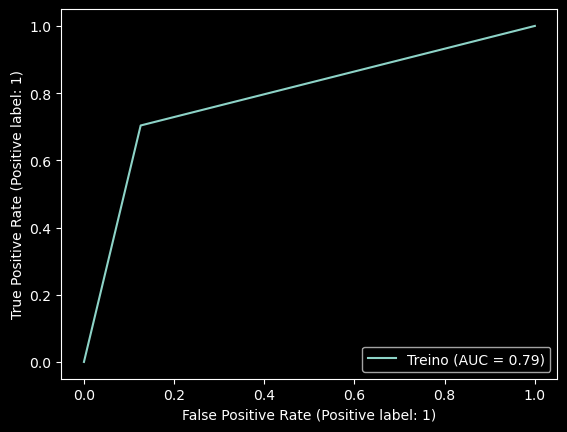

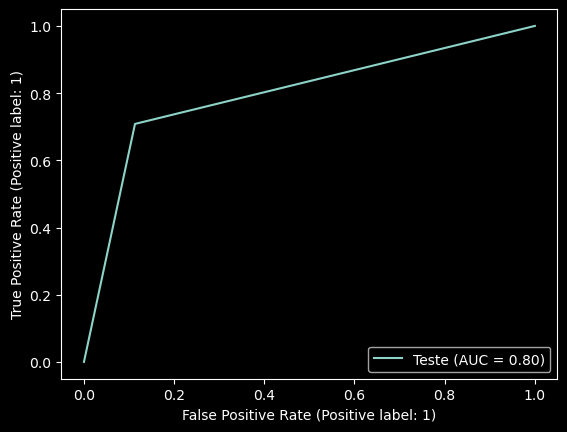

In [48]:
# Instanciando o modelo para que ele comece do zero novamente
classificador_selecionadas = DecisionTreeClassifier(random_state=5, max_depth = 3)
#######################################################################################
# Treinamento do Modelo
classificador_selecionadas.fit(x_treino_selecionadas, y_treino)

# Avaliação no conjunto de treino # Verificando Over/Under(Fitting)
previsoes_treino = classificador_selecionadas.predict(x_treino_selecionadas)
avaliar_modelo(y_treino, previsoes_treino, "Treino")

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = classificador_selecionadas.predict(x_teste_selecionadas)
avaliar_modelo(y_teste, previsoes, "Teste")
#######################################################################################

Estamos acertando uma taxa alta ainda com o modelo de Machine Learning utilizando uma quantidade menor de features.

Isso pode ser bastante útil em casos em que temos um grande conjunto de dados ou ainda, em caso de problemas para coletar certas informações a partir de todos os datasets por questões de dados sensíveis, por exemplo. Nesses casos, podemos optar por manter apenas as features para manter uma performance adequada para o modelo.

# SelectKBest

Um método alternativo para a seleção de features é a função `SelectKBest`. Essa função faz parte do módulo feature_selection da biblioteca Scikit-learn e é utilizada para selecionar as melhores características (variáveis) de um conjunto de dados com base em algum critério de avaliação. O critério mais comum é a pontuação das características em relação a uma variável alvo (supervisionada). A ideia é que, ao selecionar apenas as melhores características, o modelo resultante seja mais eficiente, mais fácil de interpretar e menos propenso a overfitting.

O parâmetro `k` na função `SelectKBest` define o número de melhores características a serem selecionadas. A função avalia todas as características do conjunto de dados e seleciona as `k` características com as pontuações mais altas de acordo com o critério escolhido.

**Vantagens da SelectKBest:**

**Dimensionamento:** A função ajuda a reduzir o dimensionamento do conjunto de dados, tornando-o mais gerenciável, o que é especialmente importante em conjuntos de dados com muitas características.
**Melhora da Performance:** A seleção de características pode melhorar o desempenho do modelo, uma vez que foca nas características mais relevantes, reduzindo o ruído presente em características menos informativas.
**Interpretação:** Modelos resultantes de conjuntos de dados com um número menor de características são mais fáceis de interpretar e visualizar, facilitando a comunicação dos resultados.

**Desvantagens da SelectKBest:**

**Informação Perdida:** A principal desvantagem é que a seleção de características no geral pode levar à perda de informações relevantes, caso algumas características menos pontuadas sejam importantes em contextos específicos.
**Dependência do Critério:** A eficácia da seleção de características depende fortemente do critério de avaliação escolhido. Um critério inadequado pode levar à seleção incorreta de características.
**Rigidez:** Fixar um número `k` de características pode não se adaptar bem a todos os conjuntos de dados. Às vezes, um número diferente de características seria mais apropriado.

Em resumo, a função `SelectKBest` é uma ferramenta útil para selecionar um subconjunto de características relevantes para a construção de modelos. No entanto, é importante pesar as vantagens e desvantagens antes de aplicá-la, considerando o contexto específico do problema, o critério de avaliação escolhido e a necessidade de interpretabilidade do modelo resultante.

# Recursive Feature Elimination (RFE) - Eliminação Recursiva de Características

**Funcionamento do RFE**

1. **Modelo de Base:**
   - RFE requer um modelo de base que possa fornecer algum tipo de importância ou coeficientes para cada característica.

2. **Processo Recursivo:**
   - O algoritmo funciona eliminando recursivamente características. Inicialmente, o modelo é treinado com todas as características disponíveis e a importância de cada característica é obtida, geralmente através de coeficientes ou de outro índice de importância fornecido pelo modelo.

3. **Eliminação:**
   - Em cada etapa, uma ou mais características consideradas as menos importantes são removidas do conjunto de dados.
   - O modelo é então re-treinado com o conjunto de características reduzido, e o processo se repete.

4. **Critério de Parada:**
   - O processo de eliminação continua até que o número desejado de características seja alcançado, ou até que o desempenho do modelo comece a deteriorar significativamente.


**Considerações**

- **Custo Computacional:** Dependendo do número inicial de características e do modelo de base utilizado, RFE pode ser computacionalmente custoso, especialmente em grandes conjuntos de dados.
- **Escolha do Modelo:** A eficácia do RFE depende significativamente do modelo de base escolhido. Modelos que fornecem medidas de importância de características imprecisas ou inadequadas podem levar a uma seleção pobre.

In [16]:
print(x_treino.shape)
print(x_teste.shape)

(534, 11)
(178, 11)


In [17]:
from sklearn.feature_selection import RFE

# Instanciando o modelo para que ele comece do zero novamente
modelo = DecisionTreeClassifier(random_state=5, max_depth = 3)

selecionador = RFE(modelo, 
                   n_features_to_select=3, 
                   step=1
                   )
#O RFE é um método recursivo de remoção de recursos. 
# No bloco acima, definimos que ele vai remover uma 
# feature a cada iteração do algoritmo.

# Treinando selecionador de features
selecionador.fit(x_treino, y_treino)

# Após isso, podemos transformar nossos dados de treino
#  e de teste, mantendo apenas as mesmas colunas das vez 
# melhores features para ambos.
x_treino_selecionadas = selecionador.transform(x_treino)
x_teste_selecionadas = selecionador.transform(x_teste)

# Treinamento do Modelo
modelo.fit(x_treino_selecionadas, y_treino)

DecisionTreeClassifier(max_depth=3, random_state=5)

**********************************************************************
Relatório de Classificação para o Conjunto de Treino :

              precision    recall  f1-score   support

           0       0.81      0.87      0.84       318
           1       0.79      0.70      0.75       216

    accuracy                           0.81       534
   macro avg       0.80      0.79      0.79       534
weighted avg       0.80      0.81      0.80       534

*******************************************************
Matriz de Confusão para o Conjunto de Treino :

[[278  40]
 [ 64 152]]
**********************************************************************


**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       106
           1       0.81      0.71      0.76        72

    accuracy                           0.81       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[94 12]
 [21 51]]
**********************************************************************


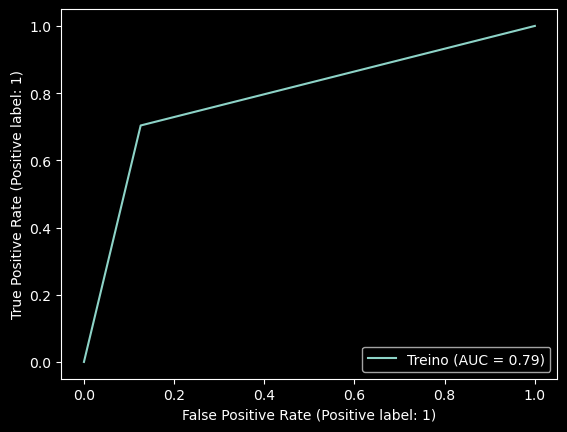

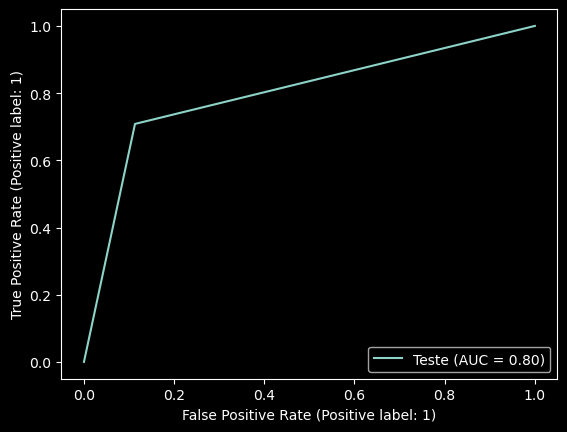

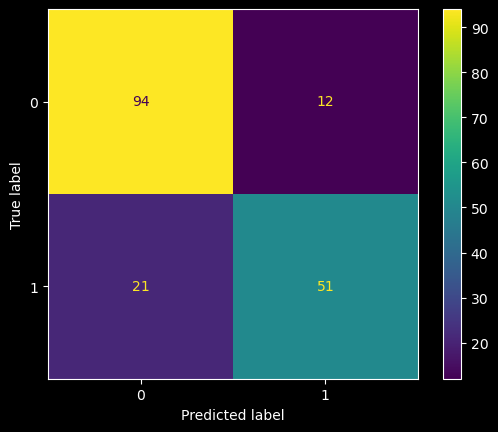

In [18]:
#######################################################################################
# Avaliação no conjunto de treino # Verificando Over/Under(Fitting)
previsoes_treino = modelo.predict(x_treino_selecionadas)
avaliar_modelo(y_treino, previsoes_treino, "Treino")

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = modelo.predict(x_teste_selecionadas)
avaliar_modelo(y_teste, previsoes, "Teste")

##############################
matriz_confusao = confusion_matrix(y_teste, previsoes)
visualizacao = ConfusionMatrixDisplay(confusion_matrix= matriz_confusao)
visualizacao.plot();
#######################################################################################

# =======================================

# Validação Cruzada

Exatamente! A validação cruzada é uma ferramenta essencial para avaliar se um modelo tem a capacidade de generalizar bem para dados novos e não vistos, fora do conjunto de treinamento. Ela ajuda a mitigar o risco de overfitting, que é quando um modelo se ajusta perfeitamente aos dados de treinamento, mas falha ao tentar prever resultados em novos conjuntos de dados. 

**Como a Validação Cruzada Ajuda a Entender a Generalização e o Overfitting**

1. **Estimativa de Desempenho Realista:** Ao usar validação cruzada, particularmente o método de validação cruzada estratificada (como `StratifiedKFold`), você obtém uma estimativa mais realista do desempenho do modelo. Cada fold funciona como um teste independente, onde o modelo é treinado em um subconjunto dos dados e testado em outro, ajudando a garantir que os resultados não sejam devidos a peculiaridades de uma divisão específica dos dados.

2. **Variabilidade das Pontuações:** Se a pontuação de um modelo varia significativamente entre os folds, isso pode indicar que o modelo é sensível a variações nos dados de treinamento, um sinal de que o modelo pode estar sobreajustado. Modelos bem generalizados tendem a ter desempenhos mais consistentes entre os diferentes folds.

3. **Comparação com o Desempenho em Dados de Treinamento:** Se as pontuações da validação cruzada forem significativamente mais baixas do que as pontuações do modelo nos dados de treinamento, isso é um forte indicativo de overfitting. Um modelo bem ajustado terá desempenho similar tanto nos dados de treinamento quanto nos dados de validação.

**Conclusão após a Validação Cruzada**

- **Decisão sobre o Modelo:** Com base nos resultados da validação cruzada, você pode decidir se um modelo é adequado ou não para continuar no processo de desenvolvimento. Se um modelo mostra sinais claros de overfitting, ou se não consegue generalizar bem segundo os resultados da validação cruzada, talvez seja necessário reconsiderar suas escolhas de hiperparâmetros, experimentar outro tipo de modelo, ou adotar técnicas para reduzir a complexidade do modelo.
  
- **Ajuste de Hiperparâmetros:** A validação cruzada não só ajuda a verificar a generalização do modelo, mas também é uma ferramenta útil para o ajuste fino dos hiperparâmetros, procurando o equilíbrio ideal entre viés e variância.

• Uma média alta sugere que o modelo está se saindo bem, enquanto uma variação alta nos scores entre os folds pode indicar que o modelo pode estar sofrendo de overfitting ou underfitting, dependendo do contexto.

• Se a pontuação de um modelo varia significativamente entre os folds, isso pode indicar que o modelo é sensível a variações nos dados de treinamento, um sinal de que o modelo pode estar sobreajustado. Modelos bem generalizados tendem a ter desempenhos mais consistentes entre os diferentes folds.

• Se as pontuações da validação cruzada forem significativamente mais baixas do que as pontuações do modelo nos dados de treinamento, isso é um forte indicativo de overfitting. Um modelo bem ajustado terá desempenho similar tanto nos dados de treinamento quanto nos dados de validação

• Decisão sobre o Modelo: Com base nos resultados da validação cruzada, você pode decidir se um modelo é adequado ou não para continuar no processo de desenvolvimento. Se um modelo mostra sinais claros de overfitting, ou se não consegue generalizar bem segundo os resultados da validação cruzada, talvez seja necessário reconsiderar suas escolhas de hiperparâmetros, experimentar outro tipo de modelo, ou adotar técnicas para reduzir a complexidade do modelo.

• Ajuste de Hiperparâmetros: A validação cruzada não só ajuda a verificar a generalização do modelo, mas também é uma ferramenta útil para o ajuste fino dos hiperparâmetros, procurando o equilíbrio ideal entre viés e variância.

Portanto, a validação cruzada é crucial para validar a robustez de um modelo de aprendizado de máquina, permitindo identificar e corrigir problemas antes de finalizar o modelo e utilizá-lo para fazer previsões em situações reais.

In [19]:
# PARA AVALIAR A VALIDAÇÃO CRUZADA
def intervalo_conf(resultados):
    media = resultados.mean()
    desvio_padrao = resultados.std()
    ic_0 = round(media - 2*desvio_padrao, 2)
    ic_1 = round(min(media + 2*desvio_padrao, 1), 2)
    ic = '[' + str(ic_0) + ' - ' + str(ic_1) + ']'
    return ic

def histograma(dados):
    dados = dados
    plt.figure(figsize=(15,5))
    plt.hist(dados, edgecolor='black', density=True) #bins=q_bins, 

    plt.title('hist', fontsize=15)
    plt.grid(True, color='gray')

    # Adicionar linhas verticais para média e mediana
    plt.axvline(x = dados.mean(), color='red', linestyle='--', label='Média')
    plt.axvline(x = dados.median(), color='blue', linestyle='--', label='Mediana')

    # Adicionar legenda personalizada
    texto_count = 'Count = ' + str(round(len(dados), 0))
    texto_media = 'Média = '+ str(round(dados.mean(), 2))
    texto_dp = 'DP = '+ str(round(dados.std(), 2))
    texto_min = 'Min = '+ str(round(dados.min(), 2))
    texto_Q1 = 'Q1 = ' + str(round(dados.quantile(0.25), 2))
    texto_mediana = 'Q2 = '+ str(round(dados.median(), 2))
    texto_Q3 = 'Q3 = ' + str(round(dados.quantile(0.75), 2))
    texto_max = 'Max = '+ str(round(dados.max(), 2))
    ic = 'IC ' + intervalo_conf(dados)
    texto_legenda = '\n'.join([texto_count, 
                               texto_min,
                               texto_media, texto_dp, 
                               texto_Q1, texto_mediana, texto_Q3,
                               texto_max, 
                               ic])

    plt.text(0.99, 0.96, texto_legenda, ha='right', va='top', transform=plt.gca().transAxes,
             bbox=dict(facecolor='black', edgecolor='gray', boxstyle='round'),
             fontsize=12)

    plt.show()

###############################################################################################
# ou pode-se tbm carregar através de:
'''
import requests
arquivo = 'funcoes_estatisticas'
url = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + arquivo + ".py"
response = requests.get(url)
code = response.text
exec(code)
'''


'\nimport requests\narquivo = \'funcoes_estatisticas\'\nurl = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + arquivo + ".py"\nresponse = requests.get(url)\ncode = response.text\nexec(code)\n'

## KFolds

**Funcionamento**

1. **Divisão do Conjunto de Dados:**
   O conjunto de dados é dividido aleatoriamente em \( k \) subconjuntos (ou "folds") de aproximadamente igual tamanho.

2. **Execução Iterativa:**
   O modelo é treinado e validado \( k \) vezes, com cada uma das \( k \) partes sendo usada exatamente uma vez como conjunto de teste, enquanto as \( k-1 \) partes restantes formam o conjunto de treino.

3. **Treinamento e Validação:**
   - Em cada iteração, o modelo é treinado com \( k-1 \) folds e testado no fold restante.
   - Isso permite que o modelo seja validado de maneira justa, utilizando todo o conjunto de dados para treino e teste ao longo das \( k \) iterações.

4. **Avaliação do Modelo:**
   - Após o treinamento, os resultados de cada fold são usados para estimar a eficácia do modelo, tipicamente através da média das métricas de desempenho (como precisão, recall, F1-score, etc.) obtidas em cada fold.

Ao escolher o valor de \( k \), um equilíbrio deve ser encontrado entre o custo computacional e a precisão da estimativa. Um valor comum é \( k=10 \), mas valores como \( k=5 \) ou \( k=20 \) também são usados dependendo do tamanho e da natureza do conjunto de dados.

,fit_time,score_time,test_score
4,0.000000,0.007684,0.773585
8,0.002598,0.000000,0.849057
0,0.003584,0.000000,0.777778


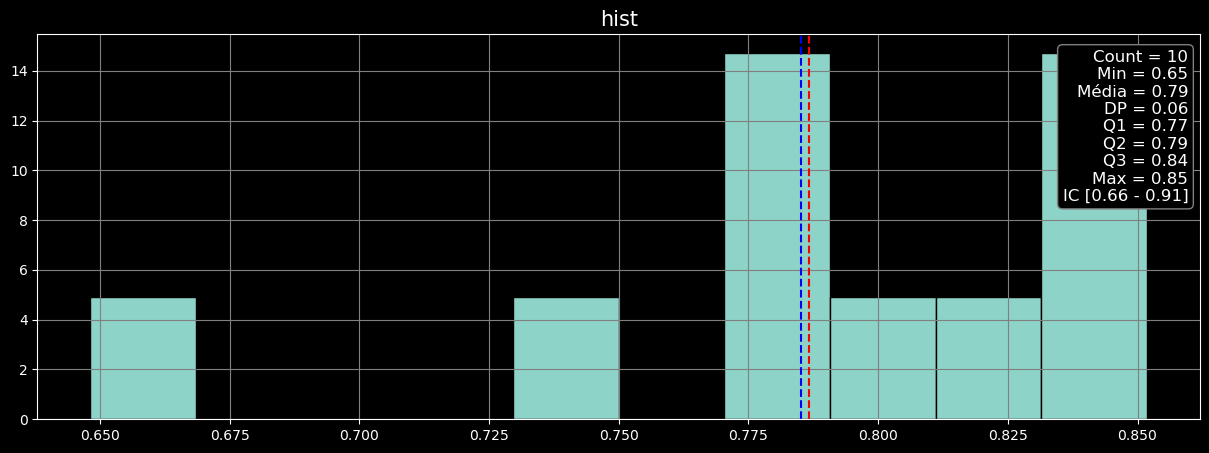

In [20]:
# VALIDAÇÃO CRUZADA
from sklearn.model_selection import cross_validate, KFold

classificador = DecisionTreeClassifier(max_depth = 10, random_state = 5)
kf = KFold(n_splits = 10, shuffle = True, random_state = 5)
cv_resultados = cross_validate(classificador, x_treino, y_treino, cv = kf)

cv_resultados = pd.DataFrame(cv_resultados)
display(cv_resultados.sample(3))

# colunas: 
# fit_time: tempo que levou para ajustar o modelo
# score_time: tempo que levou para calcular pontuação
# test_score: score obtidos pelo modelo em cada fold

# Analise graficas pontuações
histograma(cv_resultados['test_score']) # minha função de plotar histograma

import plotly.express as px
fig = px.violin(cv_resultados, x='test_score', box=True, points="all")
fig.show()

**Quando você executa cross_validate, está fazendo o seguinte:**

- **Usando o modelo 'classificador' como base:** Você passa a instância não treinada 'classificador' para cross_validate.
- **Treinamento e Teste em Folds:** O cross_validate automaticamente treina o modelo nos conjuntos de treinamento de cada fold e o testa nos conjuntos de teste correspondentes.
- **Independente do Modelo Original:** Cada fold usa uma cópia independente do modelo 'classificador'. 

Portanto, o treinamento feito durante a validação cruzada não afeta a instância original 'classificador'.
Média das Pontuações: A função calcula e retorna várias métricas, incluindo as pontuações de teste para cada fold. A média dessas pontuações é frequentemente usada para avaliar o desempenho geral do modelo.

E apartir daqui após avaliar a generalização apartir da distribuição do escore gerados, toma-se a decisão de seguir ou não com o modelo.

**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       106
           1       0.72      0.61      0.66        72

    accuracy                           0.75       178
   macro avg       0.74      0.73      0.73       178
weighted avg       0.74      0.75      0.74       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[89 17]
 [28 44]]
**********************************************************************


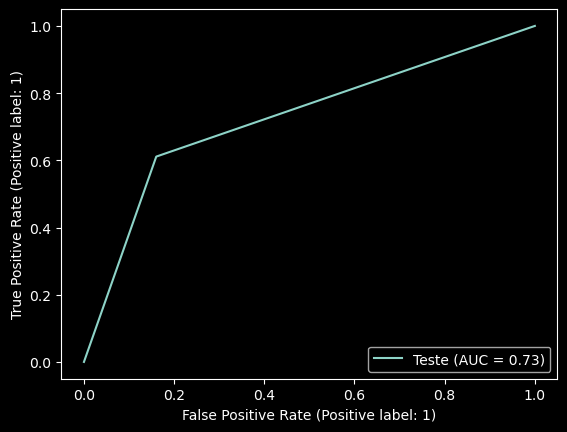

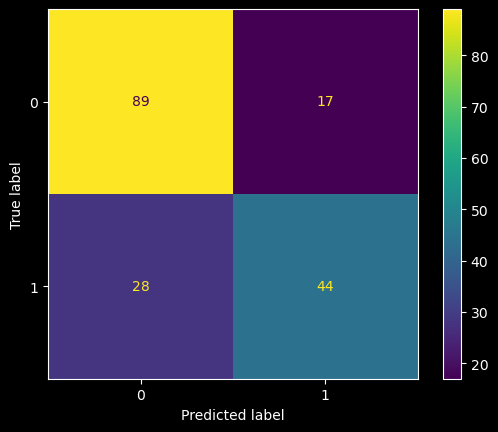

In [21]:
#######################################################################################
# Treinamento do Modelo
classificador.fit(x_treino, y_treino)

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = classificador.predict(x_teste)
avaliar_modelo(y_teste, previsoes, "Teste")

##############################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matriz_confusao = confusion_matrix(y_teste, previsoes)
visualizacao = ConfusionMatrixDisplay(confusion_matrix= matriz_confusao)
visualizacao.plot();
#######################################################################################

## StratifiedKFold - Validação Cruzada Estratificada

`StratifiedKFold` é uma variação da validação cruzada \( k \)-folds que busca melhorar a representatividade das amostras em cada fold, especialmente útil em conjuntos de dados desbalanceados. Ao invés de dividir o conjunto de dados de forma completamente aleatória, este método divide os dados de forma que a proporção de cada classe seja preservada em cada fold.

- **Melhor Representatividade:** Reduz o risco de viés no treinamento e teste devido a amostras não representativas de cada classe.
- **Maior Confiança nos Resultados:** Ao garantir que todas as classes estejam adequadamente representadas, a validação cruzada estratificada oferece uma avaliação mais precisa e confiável do desempenho do modelo.

**Funcionamento**

1. **Estratificação dos Dados:**
   Antes da divisão em \( k \) folds, o conjunto de dados é estratificado. Isso significa que a proporção de cada categoria de resposta (como "sim" ou "não" em uma variável binária) é mantida constante em cada fold.

2. **Execução Iterativa:**
   Como na validação cruzada \( k \)-folds, o modelo é treinado \( k \) vezes. Cada iteração usa um fold diferente como conjunto de teste, e os \( k-1 \) folds restantes como conjunto de treino.

3. **Treinamento e Validação:**
   - Em cada iteração, o modelo é treinado nos \( k-1 \) folds estratificados e validado no fold de teste.
   - Isso assegura que cada fold de teste é uma representação fiel da distribuição geral das classes, tornando os resultados do teste mais confiáveis.

4. **Avaliação do Modelo:**
   - A performance do modelo é avaliada em cada fold, utilizando métricas de desempenho adequadas para cada tipo de resposta. A média dessas métricas pode ser calculada para fornecer uma estimativa robusta da capacidade de generalização do modelo.

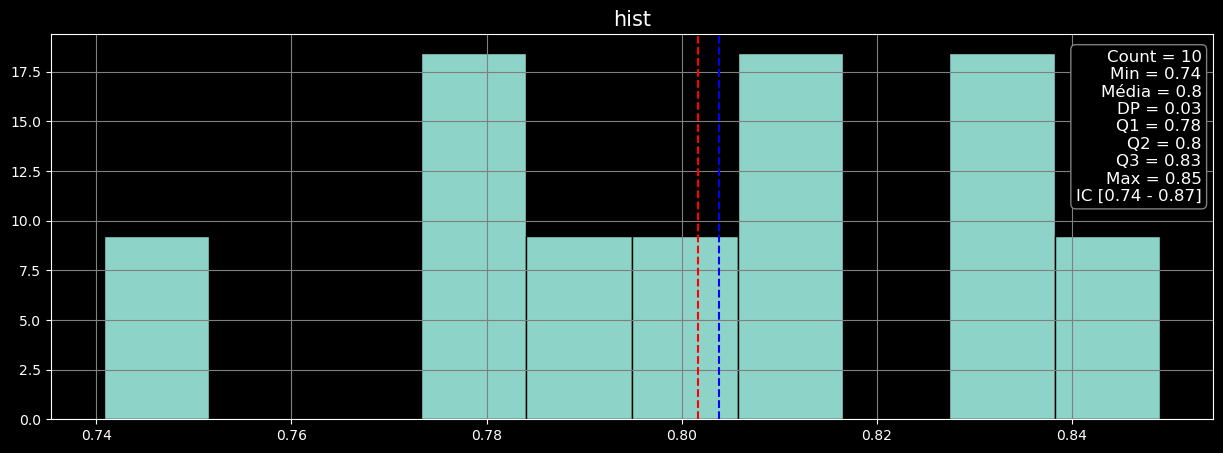

In [22]:
# VALIDAÇÃO CRUZADA ESTRATIFICADA
from sklearn.model_selection import cross_validate, StratifiedKFold

classificador = DecisionTreeClassifier(random_state=5, max_depth = 3)
skf = StratifiedKFold(n_splits = 10, 
                      shuffle = True, # embaralhamento dos dados
                      random_state = 5)
cv_resultados = cross_validate(classificador, x_treino, y_treino, cv = skf)

cv_resultados = pd.DataFrame(cv_resultados)
#display(cv_resultados.sample(3))

# colunas: 
# fit_time: tempo que levou para ajustar o modelo
# score_time: tempo que levou para calcular pontuação
# test_score: score obtidos pelo modelo em cada fold

# Analise graficas pontuações
histograma(cv_resultados['test_score']) # minha função de plotar histograma

import plotly.express as px
fig = px.violin(cv_resultados, x='test_score', box=True, points="all")
fig.show()

**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.82      0.92      0.87       106
           1       0.86      0.71      0.78        72

    accuracy                           0.84       178
   macro avg       0.84      0.82      0.82       178
weighted avg       0.84      0.84      0.83       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[98  8]
 [21 51]]
**********************************************************************


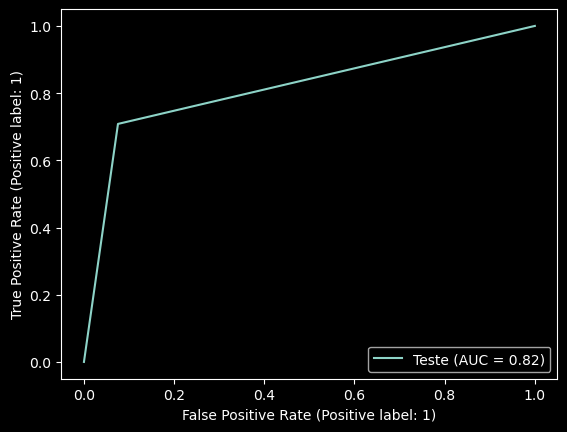

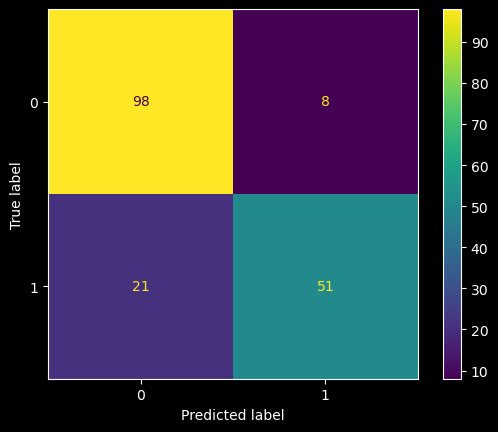

In [23]:
#######################################################################################
# Treinamento do Modelo
classificador.fit(x_treino, y_treino)

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = classificador.predict(x_teste)
avaliar_modelo(y_teste, previsoes, "Teste")

##############################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matriz_confusao = confusion_matrix(y_teste, previsoes)
visualizacao = ConfusionMatrixDisplay(confusion_matrix= matriz_confusao)
visualizacao.plot();
#######################################################################################

## RFECV
RFE-CV trata-se da junção do **algoritmo de: selecionamento de features RFE + validação cruzada StratifiedKFold**, capaz de realizar uma validação cruzada simultânea à aplicação do RFE e à seleção das melhores features.

In [24]:
from sklearn.feature_selection import RFECV

# O RFE-CV precisa de um método que ele irá utilizar
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(5, shuffle=True, random_state=500)

# Criando o RFECV
rfecv = RFECV(estimator=modelo, 
              step=1, 
              cv=cv, 
              scoring='roc_auc', # metrica para validação
              min_features_to_select=1, 
              importance_getter='auto'
              )

rfecv.fit(x_treino, y_treino)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=500, shuffle=True),
      estimator=DecisionTreeClassifier(max_depth=3, random_state=5),
      scoring='roc_auc')

Número ideal de features é: 5
Quais características foram selecionadas.: [ True False  True  True False False False  True  True False False]
O ranking das features: [1 7 1 1 6 5 4 1 1 3 2]


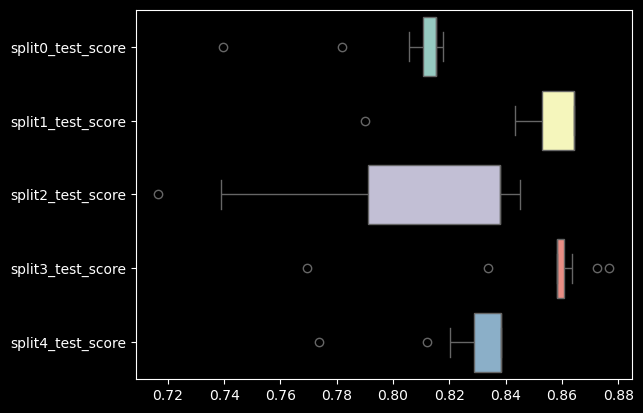

In [46]:
print(f'Número ideal de features é: {rfecv.n_features_}')

print(f'Quais características foram selecionadas.: {rfecv.support_}')
print(f'O ranking das features: {rfecv.ranking_}')

cv_results = pd.DataFrame(rfecv.cv_results_)
sns.boxplot(cv_results[cv_results.columns[2:]], orient='h');

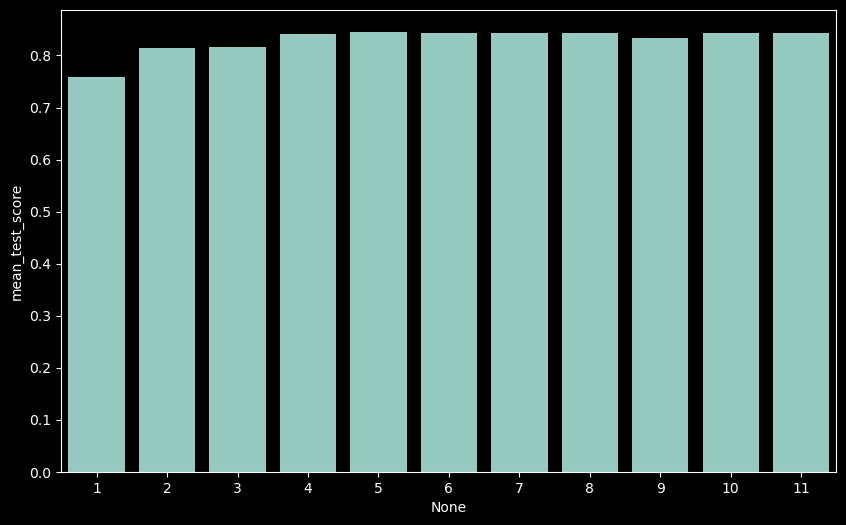

In [42]:
plt.figure(figsize=(10, 6))
sns.barplot(x=cv_results.index + 1, y='mean_test_score', data=cv_results);

Percebe-se também que, gradualmente, conforme vamos removendo as features, o valor do score diminui. Porém, até cerca de 5 ou 7 features, o valor se mantém muito próximo do que temos quando utilizamos 11 features.

Esse dado é extremamente relevante, pois cada uma dessas informações precisou ser coletada. Num cenário em que é preciso coletar ativamente uma informação, pode ser interessante coletar um número menor de dados. Nesse caso, descobrimos que o ideal foi usar 5 informações.

Contudo, se utilizássemos apenas 5 features, a perda não seria tão significativa e poderíamos coletar e armazenar uma quantidade menor de dados.

**********************************************************************
Relatório de Classificação para o Conjunto de Treino :

              precision    recall  f1-score   support

           0       0.82      0.87      0.85       318
           1       0.80      0.73      0.76       216

    accuracy                           0.81       534
   macro avg       0.81      0.80      0.80       534
weighted avg       0.81      0.81      0.81       534

*******************************************************
Matriz de Confusão para o Conjunto de Treino :

[[278  40]
 [ 59 157]]
**********************************************************************


**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       106
           1       0.81      0.71      0.76        72

    accuracy                           0.81       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[94 12]
 [21 51]]
**********************************************************************


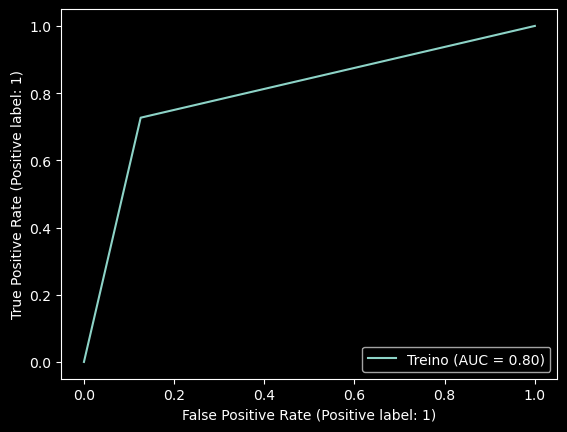

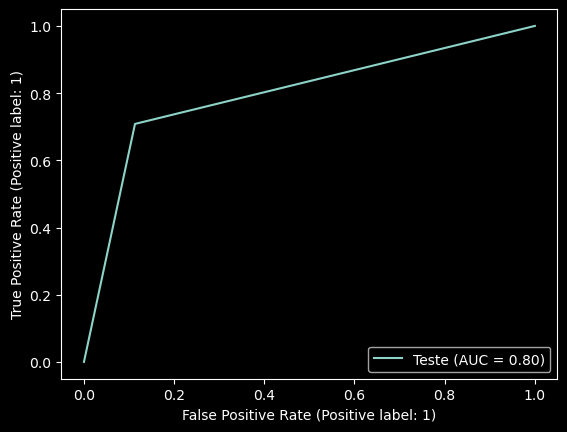

In [25]:
#######################################################################################
# Avaliação no conjunto de treino # Verificando Over/Under(Fitting)
previsoes_treino = rfecv.predict(x_treino)
avaliar_modelo(y_treino, previsoes_treino, "Treino")

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = rfecv.predict(x_teste)
avaliar_modelo(y_teste, previsoes, "Teste")

##############################
# matriz_confusao = confusion_matrix(y_teste, previsoes)
# visualizacao = ConfusionMatrixDisplay(confusion_matrix= matriz_confusao)
# visualizacao.plot();
#######################################################################################

# Balanceamento de Dados

## Oversampling - SMOTE

Abordagem avançada de oversampling usada para balancear conjuntos de dados desbalanceados, aumentando a representatividade das classes minoritárias por meio da `criação de dados sintéticos`, ao invés de simplesmente replicar os exemplos existentes.

- **Diversificação:** Ao gerar novos exemplos, SMOTE introduz uma variedade maior no conjunto de dados, o que pode ajudar a evitar o overfitting que poderia ocorrer se simplesmente duplicássemos as amostras existentes.
- **Melhoria de Modelagem:** Com um balanceamento mais efetivo entre as classes, os modelos são capazes de aprender padrões mais generalizáveis, melhorando assim a precisão das previsões em dados não vistos.

SMOTE é amplamente utilizado em problemas de classificação onde o desequilíbrio de classes é significativo, como em detecção de fraude, diagnóstico médico e predição de falhas em equipamentos.

**Funcionamento**

1. **Identificação das Amostras:**
   SMOTE analisa as características das amostras minoritárias (classe sub-representada) e identifica seus vizinhos mais próximos.

2. **Síntese de Novos Exemplos:**
   Para cada amostra na classe minoritária, são criados novos exemplos sintéticos. Isso é feito selecionando um dos \( k \) vizinhos mais próximos (geralmente \( k=5 \)) e interpolando um novo ponto entre a amostra original e o vizinho selecionado.

3. **Adição ao Conjunto de Dados:**
   Os exemplos sintéticos gerados são então adicionados ao conjunto de dados, aumentando a proporção da classe minoritária.

**Considerações**

- **Espaço de Características:** SMOTE funciona bem quando as características são contínuas. Em dados categóricos, outras técnicas de oversampling, como o ADASYN (Adaptive Synthetic Sampling Approach), podem ser mais apropriadas.
- **Risco de Overfitting:** Apesar de introduzir diversidade, a criação de muitos exemplos sintéticos pode levar a um modelo excessivamente otimista em relação aos dados de treinamento. Deve-se ter cautela com o número de exemplos sintéticos gerados.

0    318
1    318
Name: count, dtype: int64
0    0.5
1    0.5
Name: proportion, dtype: float64


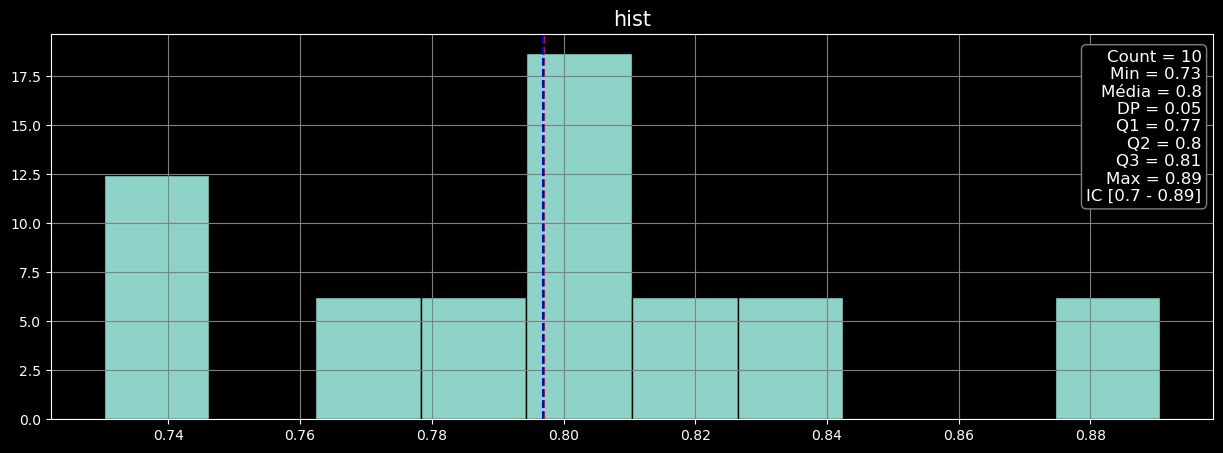

**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.79      0.84      0.81       106
           1       0.74      0.67      0.70        72

    accuracy                           0.77       178
   macro avg       0.76      0.75      0.76       178
weighted avg       0.77      0.77      0.77       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[89 17]
 [24 48]]
**********************************************************************


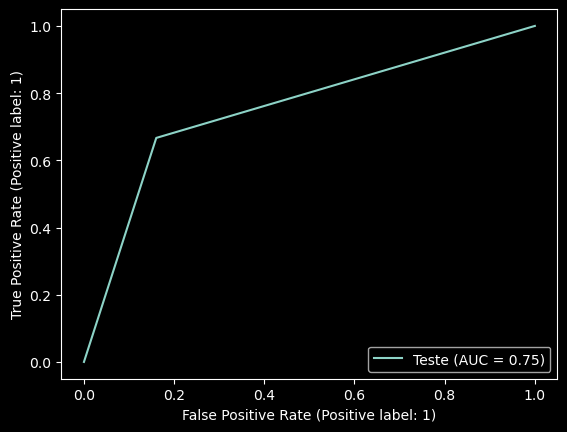

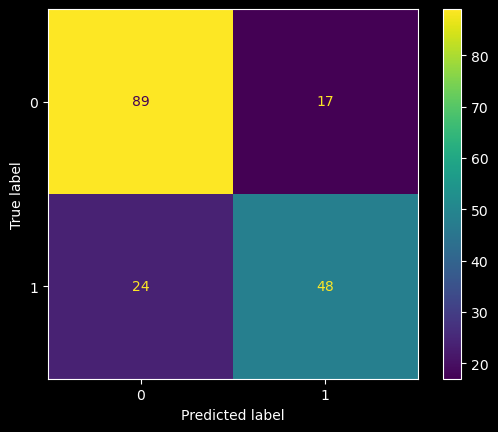

In [26]:
# BALANCEAMENTO DE DADOS - OVERSAMPLING
from imblearn.over_sampling import SMOTE

#criando dados sintéticos
oversample = SMOTE() 
x_balanceado, y_balanceado = oversample.fit_resample(x_treino, y_treino)

# checkando
print(pd.Series(y_balanceado).value_counts())
print(pd.Series(y_balanceado).value_counts(normalize = True))

#######################################################################################

#VALIDAÇÃO CRUZADA
classificador = DecisionTreeClassifier(max_depth = 10)
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 5)
cv_resultados = cross_validate(classificador, x_balanceado, y_balanceado, cv = skf)

cv_resultados = pd.DataFrame(cv_resultados['test_score'], columns=['test_score'])
histograma(cv_resultados['test_score'])

#######################################################################################
# Treinamento do Modelo
classificador.fit(x_balanceado, y_balanceado)

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = classificador.predict(x_teste)
avaliar_modelo(y_teste, previsoes, "Teste")

##############################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matriz_confusao = confusion_matrix(y_teste, previsoes)
visualizacao = ConfusionMatrixDisplay(confusion_matrix= matriz_confusao)
visualizacao.plot();
#######################################################################################

## Undersampling - NearMiss

Este método específico foca na `redução da classe majoritária`, mas com uma abordagem mais refinada que simplesmente remover amostras aleatoriamente. O NearMiss seleciona amostras da classe majoritária baseado em certos critérios de proximidade, com o objetivo de manter apenas aquelas que são mais representativas e/ou mais próximas das amostras da classe minoritária.

**Funcionamento**

1. **Critérios de Seleção:**
   NearMiss implementa diferentes versões de seleção:
   - **NearMiss-1:** Seleciona amostras da classe majoritária com a menor distância média às três amostras mais próximas da classe minoritária.
   - **NearMiss-2:** Seleciona amostras da classe majoritária com a menor distância média às três amostras mais distantes da classe minoritária.
   - **NearMiss-3:** Um subconjunto da classe minoritária é selecionado primeiro, e então, para cada exemplo na classe minoritária, são retidas as \( n \) amostras mais próximas da classe majoritária.

2. **Redução da Classe Majoritária:**
   Amostras são selecionadas de acordo com o critério estabelecido até que o número de instâncias na classe majoritária seja reduzido suficientemente para igualar o da classe minoritária.

3. **Combinação de Dados:**
   As amostras da classe majoritária que atendem aos critérios são combinadas com as da classe minoritária para formar um novo conjunto de dados balanceado.

**Considerações**

- **Perda de Informação Crítica:** Apesar da intenção de manter amostras importantes, a remoção de grandes quantidades de dados pode resultar em perda de informações cruciais.
- **Escolha do Método:** A escolha entre NearMiss-1, NearMiss-2, e NearMiss-3 pode ter um impacto significativo nos resultados, exigindo testes para determinar qual método se adapta melhor ao problema específico.

1    216
0    160
Name: count, dtype: int64
1    0.574468
0    0.425532
Name: proportion, dtype: float64


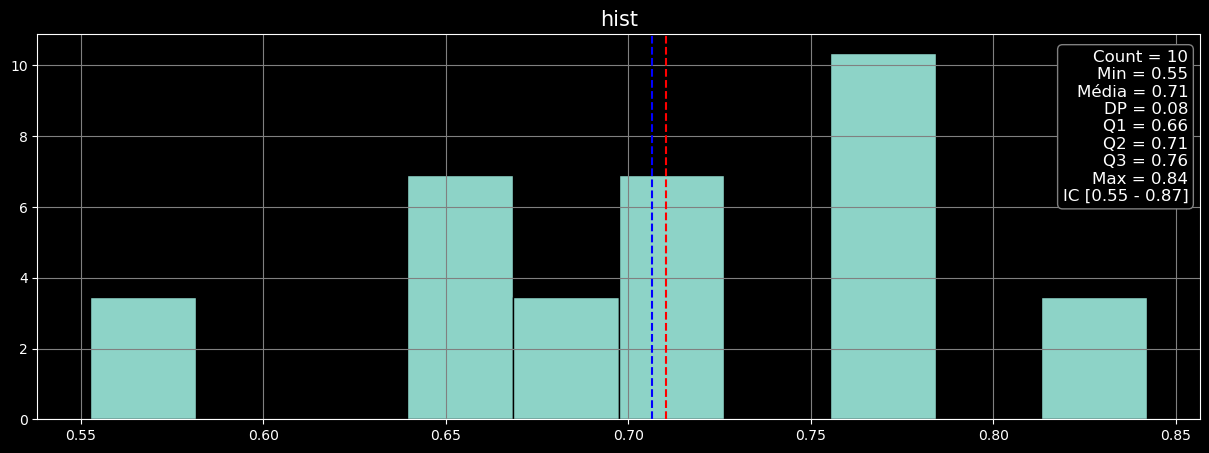

**********************************************************************
Relatório de Classificação para o Conjunto de Teste :

              precision    recall  f1-score   support

           0       0.80      0.81      0.80       106
           1       0.71      0.69      0.70        72

    accuracy                           0.76       178
   macro avg       0.76      0.75      0.75       178
weighted avg       0.76      0.76      0.76       178

*******************************************************
Matriz de Confusão para o Conjunto de Teste :

[[86 20]
 [22 50]]
**********************************************************************


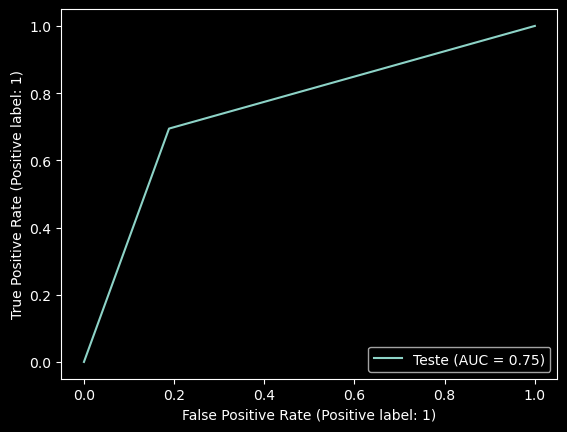

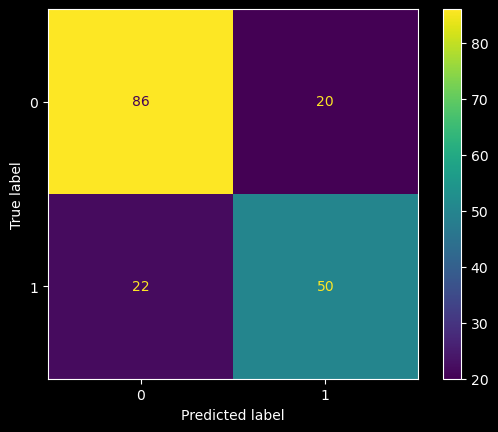

In [27]:
# BALANCEAMENTO DE DADOS - UNDERSAMPLING - NEARMISS
from imblearn.under_sampling import NearMiss

# reduzindo classe
undersample = NearMiss(version = 3)
x_balanceado, y_balanceado = undersample.fit_resample(x_treino, y_treino)

# checkando
print(pd.Series(y_balanceado).value_counts())
print(pd.Series(y_balanceado).value_counts(normalize = True))

#######################################################################################

#VALIDAÇÃO CRUZADA
classificador = DecisionTreeClassifier(max_depth = 10)
skf = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 5)
cv_resultados = cross_validate(classificador, x_balanceado, y_balanceado, cv = skf)

cv_resultados = pd.DataFrame(cv_resultados['test_score'], columns=['test_score'])
histograma(cv_resultados['test_score'])

#######################################################################################
# Treinamento do Modelo
classificador.fit(x_balanceado, y_balanceado)

# Avaliação no conjunto de teste  # Relatório de classificação
previsoes = classificador.predict(x_teste)
avaliar_modelo(y_teste, previsoes, "Teste")

##############################
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
matriz_confusao = confusion_matrix(y_teste, previsoes)
visualizacao = ConfusionMatrixDisplay(confusion_matrix= matriz_confusao)
visualizacao.plot();
#######################################################################################

## Upsampling

Essa técnica envolve `aumentar a frequência da classe minoritária` para que ela se torne comparável à da classe majoritária, ajudando a melhorar a precisão e a eficácia dos modelos de classificação.

- **Simplicidade:** O upsampling é uma técnica direta e fácil de implementar para aumentar o número de exemplos de uma classe minoritária.
- **Efetividade:** Pode melhorar significativamente a performance de modelos de aprendizado de máquina em conjuntos de dados desbalanceados.

**Funcionamento**

1. **Identificação da Classe Minoritária:**
   Primeiramente, identifica-se a classe que possui menos instâncias no conjunto de dados (classe minoritária).

2. **Replicação de Amostras:**
   Amostras da classe minoritária são replicadas aleatoriamente para aumentar sua representatividade. Isso pode ser feito até que o número de exemplos nessa classe seja igual ao da classe majoritária.

3. **Mistura com a Classe Majoritária:**
   As amostras replicadas são então misturadas de volta ao conjunto original, garantindo que a distribuição de classes seja mais equilibrada.

**Considerações**

- **Risco de Overfitting:** A replicação de instâncias pode levar a um modelo que simplesmente memoriza os dados, ao invés de aprender padrões generalizáveis. Isso é particularmente problemático quando há pouca variação nas amostras replicadas.
- **Não Adiciona Novas Informações:** Como as amostras são apenas replicadas, nenhuma informação nova é introduzida ao modelo, o que pode limitar a capacidade do modelo de aprender nuances mais complexas das classes.
- **Combinação com Downsampling:** Frequentemente, o upsampling é combinado com o downsampling da classe majoritária para criar um equilíbrio ainda mais efetivo e evitar o aumento excessivo do conjunto de dados.


In [28]:
# checkando
pd.concat([pd.Series(y_inteiro).value_counts(), pd.Series(y_inteiro).value_counts(normalize = True)], axis=1)

,count,proportion
0,424,0.595506
1,288,0.404494


In [29]:
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Separando por classe
x_inteiro_df = pd.DataFrame(x_inteiro)
y_inteiro_series = pd.Series(y_inteiro)
classe_maior = x_inteiro_df.iloc[sorted(y_inteiro_series[y_inteiro_series == 1].index)]
classe_menor = x_inteiro_df.iloc[sorted(y_inteiro_series[y_inteiro_series == 0].index)]

# Upsampling da classe minoritária
train_df_menor_upsampled = resample(classe_menor,
                                    replace=True,                # sample with replacement
                                    n_samples=len(classe_menor), # to match majority class
                                    random_state=123)            # reproducible results

# Combinando a classe majoritária com a classe minoritária upsampled
train_df_upsampled = pd.concat([classe_menor, train_df_menor_upsampled])

In [30]:
train_df_menor_upsampled.shape

(424, 11)

## Downsampling

Ao contrário do upsampling, que aumenta a frequência da classe minoritária, o downsampling `reduz a quantidade de amostras da classe majoritária` para igualar à da classe minoritária, criando um equilíbrio, tentando minimizar o viés do modelo em favor dessa classe e potencialmente melhorando a performance de modelos de classificação. 

**Funcionamento**

1. **Identificação da Classe Majoritária:**
   A primeira etapa é identificar a classe que possui mais instâncias, conhecida como classe majoritária.

2. **Redução de Amostras:**
   Amostras da classe majoritária são aleatoriamente removidas do conjunto de dados até que o número de instâncias seja equivalente ao da classe minoritária.

3. **Reintegração ao Conjunto de Dados:**
   As amostras restantes da classe majoritária são combinadas com as da classe minoritária, resultando em um conjunto de dados mais balanceado.

**Considerações**

- **Perda de Informação:** A remoção de amostras pode resultar na perda de informações importantes, potencialmente prejudicando a capacidade do modelo de aprender a generalizar a partir de dados reais.
- **Escolha de Amostras:** A seleção aleatória de amostras para remoção pode não ser a abordagem ideal; métodos mais sofisticados podem ser necessários para preservar a integridade da informação.
- **Combinação com Upsampling:** Muitas vezes, o downsampling é usado em conjunto com o upsampling para não apenas reduzir a classe majoritária, mas também aumentar a minoritária, alcançando um equilíbrio ideal.
- **Técnicas Avançadas:** Métodos como clustering ou análises de importância de instâncias podem ser utilizados para escolher quais amostras remover, assegurando que as mais representativas e informativas sejam mantidas.

# FIM